# Mount drive, import libraries

In [ ]:
from google.colab import drive
drive.mount('/content/drive')
%cd '/content/drive/MyDrive/AI'

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
/content/drive/MyDrive/AI


In [ ]:
import numpy as np
import pandas as pd
import pickle

In [ ]:
import torch
from torch import nn, optim
from torch.nn import functional as F
import torch.autograd as autograd
torch.manual_seed(1)
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu') #'cuda:0'

In [ ]:
!pip install pyvi
from pyvi import ViPosTagger

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
%pip install conlleval
from conlleval import evaluate

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


# Read Pretrained data

In [ ]:
pretrain_data_0 = pd.read_csv('pretrained100.txt', sep=" ",header = None, skiprows = 1, nrows = 100000)
pretrain_data_1 = pd.read_csv('pretrained100.txt', sep=" ",header = None, skiprows = 100001, nrows = 100000)
pretrain_data_2 = pd.read_csv('pretrained100.txt', sep=" ",header = None, skiprows = 200001, nrows = 100000)
pretrain_data_3 = pd.read_csv('pretrained100.txt', sep=" ",header = None, skiprows = 300001, nrows = 100000)
pretrain_data = pd.concat([pretrain_data_0, pretrain_data_1, pretrain_data_2, pretrain_data_3])

In [ ]:
print(pretrain_data.shape)
pretrain_data.head()

(400000, 101)


,0,1,2,3,4,5,6,7,8,9,...,91,92,93,94,95,96,97,98,99,100
0,",",-0.013445,0.082912,0.095113,0.052493,0.069441,-0.010651,0.004321,-0.082824,0.051480,...,-0.099876,0.020649,-0.066902,0.077416,-0.147332,-0.021268,0.019100,-0.138095,0.077689,-0.210762
1,.,0.080173,0.048418,0.058027,0.055044,0.023451,-0.000025,0.000599,-0.071703,0.054242,...,-0.183366,0.039830,-0.010186,0.075011,-0.128598,-0.020384,0.029758,-0.172362,0.126670,-0.188354
2,và,0.013720,0.058717,0.110645,0.066075,0.046535,-0.004956,-0.003579,-0.033581,0.043340,...,-0.128276,-0.011903,-0.048510,0.085721,-0.133140,0.005551,0.043090,-0.154915,0.148186,-0.196749
3,của,0.026101,0.033375,0.166609,0.013060,0.017971,0.006579,0.067402,0.002216,0.116908,...,-0.137093,0.036225,-0.026152,0.148379,-0.151303,-0.039304,0.016051,-0.123603,0.107642,-0.222042
4,là,0.031769,0.048661,0.138932,-0.068711,0.049129,-0.014016,0.066129,0.013496,0.028830,...,-0.124612,0.031029,-0.069093,0.085157,-0.106477,-0.006654,-0.006391,-0.161527,0.107603,-0.208509


In [ ]:
word_embedding_dict = {}
border = np.sqrt(3/100)
count = 0
for word in list_of_words:
  if pretrain_data.loc[pretrain_data[0] == word].shape[0] == 0:
    word_embedding_dict[word] = np.random.uniform(-border,border, 100).tolist()
  else:
    temp = []
    for x in range(1, 101):
      _ = pretrain_data.loc[pretrain_data[0] == word, x].values[0]
      temp.append(_)
    word_embedding_dict[word] = temp

In [ ]:
len(word_embedding_dict)

7886

In [ ]:
import pickle

In [ ]:
import pickle
with open('saved_dictionary.pkl', 'wb') as f:
    pickle.dump(word_embedding_dict, f)

"with open('saved_dictionary.pkl', 'rb') as f:\n    loaded_dict = pickle.load(f)"

# Data Preprocessing

In [ ]:
with open('saved_dictionary.pkl', 'rb') as f: #read from a pretrained word-embedding file
    loaded_dict = pickle.load(f)

border = np.sqrt(3/100)
loaded_dict['UNK'] = np.random.uniform(-border,border, 100).tolist()

In [ ]:
trainset = pd.read_csv('train_word.csv')[['sent', 'anno']]
print(f"Dataset's shape: {trainset.shape}")
trainset.head(3)

Dataset's shape: (5027, 2)


,sent,anno
0,"Đồng_thời , bệnh_viện tiếp_tục thực_hiện các b...",O O O O O O O O O O O O O O O B-ORGANIZATION I...
1,""" Số bệnh_viện có_thể tiếp_nhận bệnh_nhân bị s...",O O O O O O O B-SYMPTOM_AND_DISEASE I-SYMPTOM_...
2,"Ngoài_ra , những người tiếp_xúc gián_tiếp ( đã...",O O O O O O O O O O O O O O O O O O O O O O O ...


In [ ]:
testset = pd.read_csv('test_word.csv')[['sent', 'anno']]
print(f"Dataset's shape: {testset.shape}")
testset.head(3)

Dataset's shape: (4000, 2)


,sent,anno
0,"Từ 24 - 7 đến 31 - 7 , bệnh_nhân được mẹ là bà...",O B-DATE I-DATE I-DATE O B-DATE I-DATE I-DATE ...
1,"Bác_sĩ Trần_Thanh_Linh , từ Bệnh_viện Chợ_Rẫy ...",O O O O B-ORGANIZATION I-ORGANIZATION O O O O ...
2,"Theo đó , Sở Y_tế Bình_Thuận cho biết sau khi ...",O O O B-ORGANIZATION I-ORGANIZATION I-ORGANIZA...


In [ ]:
validset = pd.read_csv('val_word.csv')[['sent', 'anno']]
print(f"Dataset's shape: {validset.shape}")
validset.head(3)

Dataset's shape: (1000, 2)


,sent,anno
0,"Bác_sĩ Nguyễn_Trung_Nguyên , Giám_đốc Trung_tâ...",O O O O B-ORGANIZATION I-ORGANIZATION I-ORGANI...
1,""" Bệnh_nhân 812 "" , nam , 62 tuổi , là nhân_vi...",O O B-PATIENT_ID O O B-GENDER O B-AGE O O O B-...
2,Trong số những người mà cô ấy đã tiếp_xúc với ...,O O O O O O O O O O O O B-ORGANIZATION O


In [ ]:
word_to_ix = {}
tag_to_ix = {}
START_TAG = "<START>"
STOP_TAG = "<STOP>"
tag_to_ix[START_TAG] = 0
tag_to_ix[STOP_TAG] = 1
word_to_ix['UNK'] = 0

for sentences, tags in zip(trainset['sent'].tolist(),trainset['anno'].tolist()):
  for word in sentences.split():
    if word not in word_to_ix.keys():
      word_to_ix[word] = len(word_to_ix)
  for tag in tags.split():
    if tag not in tag_to_ix.keys():
      tag_to_ix[tag] = len(tag_to_ix)

In [ ]:
print(tag_to_ix)

{'<START>': 0, '<STOP>': 1, 'O': 2, 'B-ORGANIZATION': 3, 'I-ORGANIZATION': 4, 'B-SYMPTOM_AND_DISEASE': 5, 'I-SYMPTOM_AND_DISEASE': 6, 'B-LOCATION': 7, 'B-DATE': 8, 'B-PATIENT_ID': 9, 'B-AGE': 10, 'B-NAME': 11, 'I-DATE': 12, 'B-JOB': 13, 'I-LOCATION': 14, 'B-TRANSPORTATION': 15, 'B-GENDER': 16, 'I-TRANSPORTATION': 17, 'I-JOB': 18, 'I-NAME': 19, 'I-AGE': 20, 'I-PATIENT_ID': 21}


In [ ]:
print(f"Number of distinct words: {len(word_to_ix)-1}")

Number of distinct words: 5167


In [ ]:
word2tag = dict()
word2tag['word'] = list()
word2tag['tag'] = list()

for sentences, tags in zip(trainset['sent'].tolist(), trainset['anno'].tolist()):
  for word, tag in zip (sentences.split(), tags.split()):
    word2tag['word'].append(word)
    word2tag['tag'].append(tag)
dataset_df = pd.DataFrame(word2tag)

In [ ]:
dataset_df.head()

,word,tag
0,Đồng_thời,O
1,",",O
2,bệnh_viện,O
3,tiếp_tục,O
4,thực_hiện,O


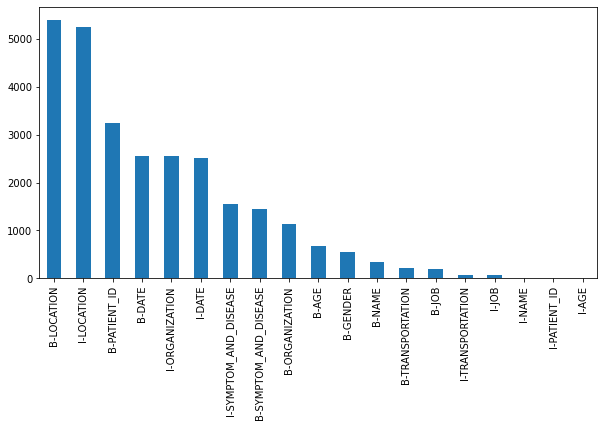

In [ ]:
dataset_df[dataset_df["tag"]!="O"]["tag"].value_counts().plot(kind="bar", figsize=(10,5))

In [ ]:
print(f"Number of unique tag is {len(tag_to_ix)-2}")
print(f"Number of unique word is {len(word_to_ix)}")

Number of unique tag is 20
Number of unique word is 5168


In [ ]:
full_text = ""

for word in word_to_ix.keys():
  full_text += word
  full_text += " "

int2char = dict(enumerate(set(full_text)))
char2int = {ch: ii for ii, ch in int2char.items()}
int2char[len(char2int)] = 'UNK'
char2int['UNK'] = len(char2int)

list_of_pos = {
    'X': 0,  #<Unk>
    'A': 1,
    'C': 2,
    'E': 3,
    'I': 4,
    'L': 5,
    'M': 6,
    'N': 7,
    'Nc': 8,
    'Ny': 9,
    'Np': 10,
    'Nu': 11,
    'P': 12,
    'R': 13,
    'S': 14,
    'T': 15,
    'V': 16,
    'F': 17
}

def one_hot_encode(index, n_labels):
    one_hot = [0] * n_labels
    one_hot[index] = 1
    return one_hot

In [ ]:
print(char2int)

{'I': 0, 'é': 1, 'ỡ': 2, 'ố': 3, 'Ă': 4, 'ằ': 5, 'ề': 6, '￼': 7, 'G': 8, 'Ả': 9, 'ậ': 10, 'ỵ': 11, 'E': 12, 'z': 13, 'r': 14, 'h': 15, 'Ổ': 16, 'í': 17, '&': 18, 'N': 19, 'ụ': 20, 'X': 21, 'ợ': 22, '_': 23, 'Ễ': 24, 'g': 25, ':': 26, 'H': 27, 'Ô': 28, 'S': 29, '/': 30, 'ả': 31, 'ạ': 32, 'ẻ': 33, 'o': 34, '5': 35, 'ắ': 36, 'u': 37, 'Ú': 38, 'Q': 39, 'ỹ': 40, 'Ư': 41, 's': 42, 'ê': 43, '2': 44, 'à': 45, 'Á': 46, 'C': 47, 'k': 48, 'ữ': 49, 'ỗ': 50, '.': 51, '…': 52, 'ọ': 53, 'ẳ': 54, 'n': 55, 'l': 56, '1': 57, 'L': 58, '4': 59, 'V': 60, 'è': 61, 'Y': 62, 'ổ': 63, ' ': 64, 'đ': 65, ';': 66, '?': 67, 'ă': 68, 'W': 69, 'ẩ': 70, ')': 71, 'ừ': 72, 'w': 73, 'Â': 74, '8': 75, 'Ĩ': 76, 'ỳ': 77, 'ẵ': 78, '7': 79, 'ó': 80, 'ặ': 81, 'ỷ': 82, 'á': 83, 'B': 84, 'ở': 85, 'ỉ': 86, 'ầ': 87, 'ã': 88, 'Í': 89, 'x': 90, 'Ở': 91, '9': 92, 'D': 93, 'e': 94, '3': 95, 'ễ': 96, '"': 97, 'ộ': 98, 'ự': 99, 'J': 100, 'õ': 101, 'Ấ': 102, 'p': 103, '\u200b': 104, 'ẹ': 105, 'ủ': 106, '*': 107, 'ô': 108, '+': 109, 'Ý':

In [ ]:
training_data = []
for sent, tag in zip(trainset['sent'].tolist(), trainset['anno'].tolist()):
  list_word = sent.split()
  embed = []
  sequence_pos = []
  list_tag = [tag_to_ix[t] for t in tag.split()]
  sequence_char = []
  for word in list_word:
    embed.append(loaded_dict[word])
    temp = []
    for ch in list(word):
      temp.append(char2int[ch])
    sequence_char.append(temp)
  for pos in ViPosTagger.postagging(sent)[1]:
    sequence_pos.append(one_hot_encode(list_of_pos[pos], len(list_of_pos)))

  training_data.append((list_word, embed, list_tag, sequence_pos, sequence_char))

In [ ]:
validating_data = []
for sent, tag in zip(validset['sent'].tolist(), validset['anno'].tolist()):
  list_word = sent.split()
  embed = []
  sequence_pos = []
  list_tag = [tag_to_ix[t] for t in tag.split()]
  sequence_char = []
  for word in list_word:
    if word not in loaded_dict:
      embed.append(loaded_dict['UNK'])
    else:
      embed.append(loaded_dict[word])
    temp = []
    for ch in list(word):
      if ch not in char2int:
        temp.append(char2int['UNK'])
      else:
        temp.append(char2int[ch])
    sequence_char.append(temp)
  for pos in ViPosTagger.postagging(sent)[1]:
    sequence_pos.append(one_hot_encode(list_of_pos[pos], len(list_of_pos)))

  validating_data.append((list_word, embed, list_tag, sequence_pos, sequence_char))

In [ ]:
testing_data = []
for sent, tag in zip(testset['sent'].tolist(), testset['anno'].tolist()):
  list_word = sent.split()
  embed = []
  sequence_pos = []
  list_tag = [tag_to_ix[t] for t in tag.split()]
  sequence_char = []
  for word in list_word:
    if word not in loaded_dict:
      embed.append(loaded_dict['UNK'])
    else:
      embed.append(loaded_dict[word])
    temp = []
    for ch in list(word):
      if ch not in char2int:
        temp.append(char2int['UNK'])
      else:
        temp.append(char2int[ch])
    sequence_char.append(temp)
  for pos in ViPosTagger.postagging(sent)[1]:
    sequence_pos.append(one_hot_encode(list_of_pos[pos], len(list_of_pos)))
  testing_data.append((list_word, embed, list_tag, sequence_pos, sequence_char))

In [ ]:
print(training_data[10][0])
print(training_data[10][2])
print(training_data[10][3])
print(training_data[10][4])

['Hôm_qua', ',', 'hai', 'bệnh_nhân', 'Covid', '-', '19', 'cũng', 'tử_vong', ',', 'có', 'bệnh', 'nền', 'suy', 'thận', 'mạn', '.']
[2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 5, 6, 6, 2]
[[0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1], [0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1], [0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0], [0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0], [0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 

In [ ]:
print(len(training_data))
print(len(validating_data))
print(len(testing_data))

5027
1000
4000


# Model

In [ ]:
def argmax(vec):
    _, idx = torch.max(vec, 1)
    return idx.item()

def log_sum_exp(vec):
    max_score = vec[0, argmax(vec)]
    max_score_broadcast = max_score.view(1, -1).expand(1, vec.size()[1])
    return max_score + torch.log(torch.sum(torch.exp(vec - max_score_broadcast)))

def generate_batch(df, size):
    sent_list = []
    embeds_list = []
    tags_list = []
    pos_list = []
    char_list = []
    for item in df:
        sent_list.append(item[0])
        embeds_list += item[1]
        tags_list += item[2]
        pos_list += item[3]
        char_list += item[4]
        if len(sent_list) == size:
            yield sent_list, embeds_list, tags_list, pos_list, char_list
            sent_list = []
            embeds_list = []
            tags_list = []
            pos_list = []
            char_list = []
            
class CharEmbedding(nn.Module):
  def __init__(self, embeddingSize ,hiddenSize, charSize):
    super(CharEmbedding, self).__init__()
    self.embeddingSize = embeddingSize
    self.hiddenSize = hiddenSize
    self.embed = nn.Embedding(charSize, embeddingSize)
    self.BiLSTM = nn.LSTM(embeddingSize, hiddenSize, batch_first = True, bidirectional=True)

  def forward(self, sentence):
    embeddingMatrix = torch.empty(size = (len(sentence), self.hiddenSize*2))
    hidden, cell = (torch.randn(2, 1, self.hiddenSize),
                    torch.randn(2, 1, self.hiddenSize))
    for i, word in enumerate(sentence):
      for char in word:
        embeds = self.embed(torch.tensor(char))
        out, (hidden, cell) = self.BiLSTM(embeds.view(1, 1, -1), (hidden, cell))
      embeddingMatrix[i] = out
    return embeddingMatrix

class BiLSTM_CRF(nn.Module):

    def __init__(self, vocab_size, tag_to_ix, embedding_dim, hidden_dim):
        super(BiLSTM_CRF, self).__init__()
        self.embedding_dim = embedding_dim
        self.hidden_dim = hidden_dim
        self.vocab_size = vocab_size
        self.tag_to_ix = tag_to_ix
        self.tagset_size = len(tag_to_ix)

        self.lstm = nn.LSTM(embedding_dim, hidden_dim // 2,num_layers=1, bidirectional=True)

        # Maps the output of the LSTM into tag space.
        self.hidden2tag = nn.Linear(hidden_dim, self.tagset_size)

        # Matrix of transition parameters.  Entry i,j is the score of
        # transitioning *to* i *from* j.
        self.transitions = nn.Parameter(torch.randn(self.tagset_size, self.tagset_size))

        # These two statements enforce the constraint that we never transfer
        # to the start tag and we never transfer from the stop tag
        self.transitions.data[tag_to_ix[START_TAG], :] = -10000
        self.transitions.data[:, tag_to_ix[STOP_TAG]] = -10000

        self.hidden = self.init_hidden()

    def init_hidden(self):
        hidden = (torch.randn(2, 1, self.hidden_dim // 2),torch.randn(2, 1, self.hidden_dim // 2))
        return hidden

    def _forward_alg(self, feats):
        # Do the forward algorithm to compute the partition function
        init_alphas = torch.full((1, self.tagset_size), -10000.)
        # START_TAG has all of the score.
        init_alphas[0][self.tag_to_ix[START_TAG]] = 0.

        # Wrap in a variable so that we will get automatic backprop
        forward_var = init_alphas
        forward_var = forward_var
        # Iterate through the sentence
        for feat in feats:
            alphas_t = []  # The forward tensors at this timestep
            for next_tag in range(self.tagset_size):
                # broadcast the emission score: it is the same regardless of
                # the previous tag
                emit_score = feat[next_tag].view(1, -1).expand(1, self.tagset_size)
                # the ith entry of trans_score is the score of transitioning to
                # next_tag from i
                trans_score = self.transitions[next_tag].view(1, -1)
                # The ith entry of next_tag_var is the value for the
                # edge (i -> next_tag) before we do log-sum-exp
                next_tag_var = forward_var + trans_score + emit_score
                # The forward variable for this tag is log-sum-exp of all the
                # scores.
                alphas_t.append(log_sum_exp(next_tag_var).view(1))
            forward_var = torch.cat(alphas_t).view(1, -1)
        terminal_var = forward_var + self.transitions[self.tag_to_ix[STOP_TAG]]
        alpha = log_sum_exp(terminal_var)
        return alpha

    def _get_lstm_features(self, sentence):
        self.hidden = self.init_hidden()
        embeds = sentence.view(len(sentence), 1, -1)     #self.word_embeds(sentence).view(len(sentence), 1, -1)
        lstm_out, self.hidden = self.lstm(embeds, self.hidden)
        lstm_out = lstm_out.view(len(sentence), self.hidden_dim)
        lstm_feats = self.hidden2tag(lstm_out)
        return lstm_feats

    def _score_sentence(self, feats, tags):
        # Gives the score of a provided tag sequence
        score = torch.zeros(1)
        tags = torch.cat([torch.tensor([self.tag_to_ix[START_TAG]], dtype=torch.long), tags])
        for i, feat in enumerate(feats):
            score = score + self.transitions[tags[i + 1], tags[i]] + feat[tags[i + 1]]
        score = score + self.transitions[self.tag_to_ix[STOP_TAG], tags[-1]]
        return score

    def _viterbi_decode(self, feats):
        backpointers = []

        # Initialize the viterbi variables in log space
        init_vvars = torch.full((1, self.tagset_size), -10000.)
        init_vvars[0][self.tag_to_ix[START_TAG]] = 0

        # forward_var at step i holds the viterbi variables for step i-1
        forward_var = init_vvars
        forward_var = forward_var
        
        for feat in feats:
            bptrs_t = []  # holds the backpointers for this step
            viterbivars_t = []  # holds the viterbi variables for this step

            for next_tag in range(self.tagset_size):
                # next_tag_var[i] holds the viterbi variable for tag i at the
                # previous step, plus the score of transitioning
                # from tag i to next_tag.
                # We don't include the emission scores here because the max
                # does not depend on them (we add them in below)
                
                next_tag_var = forward_var + self.transitions[next_tag]
                best_tag_id = argmax(next_tag_var)
                bptrs_t.append(best_tag_id)
                viterbivars_t.append(next_tag_var[0][best_tag_id].view(1))
            # Now add in the emission scores, and assign forward_var to the set
            # of viterbi variables we just computed
            forward_var = (torch.cat(viterbivars_t) + feat).view(1, -1)
            backpointers.append(bptrs_t)

        # Transition to STOP_TAG
        terminal_var = forward_var + self.transitions[self.tag_to_ix[STOP_TAG]]
        best_tag_id = argmax(terminal_var)
        path_score = terminal_var[0][best_tag_id]

        # Follow the back pointers to decode the best path.
        best_path = [best_tag_id]
        for bptrs_t in reversed(backpointers):
            best_tag_id = bptrs_t[best_tag_id]
            best_path.append(best_tag_id)
        # Pop off the start tag (we dont want to return that to the caller)
        start = best_path.pop()
        assert start == self.tag_to_ix[START_TAG]  # Sanity check
        best_path.reverse()
        return path_score, best_path

    def neg_log_likelihood(self, sentence, tags):
        feats = self._get_lstm_features(sentence)
        forward_score = self._forward_alg(feats)
        gold_score = self._score_sentence(feats, tags)
        return forward_score - gold_score

    def forward(self, sentence):  # dont confuse this with _forward_alg above.
        # Get the emission scores from the BiLSTM
        lstm_feats = self._get_lstm_features(sentence)

        # Find the best path, given the features.
        score, tag_seq = self._viterbi_decode(lstm_feats)
        return score, tag_seq

# WordEmbedding

In [ ]:
EMBEDDING_DIM = 100
HIDDEN_DIM = 200

#char
embeddingSize = 10
hiddenSize = 25
charSize = len(char2int)

EPOCHS = 10
BATCH_SIZE = 32
LEARNING_RATE = 1e-3

In [ ]:
model = BiLSTM_CRF(len(word_to_ix), tag_to_ix, EMBEDDING_DIM, HIDDEN_DIM)
optimizer = optim.Adam(model.parameters(), lr = LEARNING_RATE)

In [ ]:
import time

patience = 2
trigger = 0

list_word = []
list_tag = []

for i in range(len(validating_data)):
    list_word.extend(validating_data[i][1])
    list_tag.extend(validating_data[i][2])

with torch.no_grad():
  test = torch.tensor(list_word, dtype = torch.float32)
  last_loss = model.neg_log_likelihood(test, torch.tensor(list_tag)).item()
  print(f"Validation Loss before training: {last_loss}")
for epoch in range(EPOCHS):
    print(f"Epoch: {epoch+1}/{EPOCHS}")
    start_time = time.time()

    for index, (sent, embeds, tags, pos, char) in enumerate(generate_batch(training_data, BATCH_SIZE)):
        model.zero_grad()

        inputs = torch.tensor(embeds, dtype = torch.float32)
        targets = torch.tensor(tags)
        
        train_loss = model.neg_log_likelihood(inputs, targets)
        train_loss.backward()
        optimizer.step()
      
        print(index, end = " ")
        if index % 5 == 0:
          torch.save(model.state_dict(), '/content/drive/MyDrive/AI/WordEmbed.pt')     
    with torch.no_grad():
      test = torch.tensor(list_word, dtype = torch.float32)
      current_loss = model.neg_log_likelihood(test, torch.tensor(list_tag)).item()
    if current_loss > last_loss:
      trigger += 1
    else:
      last_loss = current_loss
    if trigger == patience:
      break
    print(f"epoch {epoch+1}/{EPOCHS} with time: {time.time() - start_time} - validloss: {current_loss}") 
    start_time = time.time()

Validation Loss before training: 91002.3203125
Epoch: 1/10
0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71 72 73 74 75 76 77 78 79 80 81 82 83 84 85 86 87 88 89 90 91 92 93 94 95 96 97 98 99 100 101 102 103 104 105 106 107 108 109 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125 126 127 128 129 130 131 132 133 134 135 136 137 138 139 140 141 142 143 144 145 146 147 148 149 150 151 152 153 154 155 156 epoch 1/10 with time: 1006.3140444755554 - validloss: 34643.6796875
Epoch: 2/10
0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71 72 73 74 75 76 77 78 79 80 81 82 83 84 85 86 87 88 89 90 91 92 93 94 95 96 97 98 99 100 101 102 103 104 105 106 107 108 109 110 111 112 1

In [ ]:
torch.save(model.state_dict(), '/content/drive/MyDrive/AI/WordEmbed.pt')

**PREDICT**

In [ ]:
EMBEDDING_DIM = 100
HIDDEN_DIM = 200

#char
embeddingSize = 10
hiddenSize = 25
charSize = len(char2int)

EPOCHS = 10
BATCH_SIZE = 32
LEARNING_RATE = 1e-3

model = BiLSTM_CRF(len(word_to_ix), tag_to_ix, EMBEDDING_DIM, HIDDEN_DIM)
optimizer = optim.Adam(model.parameters(), lr = LEARNING_RATE)

model.load_state_dict(torch.load('WordEmbed.pt'))

<All keys matched successfully>

In [ ]:
f = open("predict1.txt", "w", encoding="utf-8")

for index, (sent, embeds, tags, pos, char) in enumerate(testing_data):
  inputs = torch.tensor(embeds, dtype=torch.float32)
  targets = torch.tensor(tags)
  _, pred_targets = model(inputs)
  pred_tag = [list(tag_to_ix.keys())[list(tag_to_ix.values()).index(tag)] for tag in pred_targets]
  true_tag = [list(tag_to_ix.keys())[list(tag_to_ix.values()).index(tag)] for tag in targets]
  for word, tags, pred in zip(testing_data[index][0], true_tag, pred_tag):
    f.write("{} a {} {}\n".format(word, tags, pred))

In [ ]:
!python conlleval.py < predict1.txt > result1.txt

In [ ]:
path = '/content/drive/MyDrive/AI/result1.txt'
with open(path, 'r') as result:
  print(result.read())

processed 108242 tokens with 14482 phrases; found: 11756 phrases; correct: 10127.
accuracy:  70.48%; (non-O)
accuracy:  91.63%; precision:  86.14%; recall:  69.93%; FB1:  77.19
              AGE: precision:  91.26%; recall:  90.88%; FB1:  91.07  721
             DATE: precision:  88.06%; recall:  79.04%; FB1:  83.30  1884
           GENDER: precision:  93.97%; recall:  89.24%; FB1:  91.54  547
              JOB: precision:  53.06%; recall:  11.93%; FB1:  19.48  49
         LOCATION: precision:  86.52%; recall:  67.72%; FB1:  75.97  4183
             NAME: precision:  86.67%; recall:  20.86%; FB1:  33.62  90
     ORGANIZATION: precision:  66.40%; recall:  58.29%; FB1:  62.08  863
       PATIENT_ID: precision:  90.50%; recall:  83.00%; FB1:  86.59  2326
SYMPTOM_AND_DISEASE: precision:  80.81%; recall:  53.51%; FB1:  64.39  933
   TRANSPORTATION: precision:  88.12%; recall:  64.38%; FB1:  74.41  160



# WordEmbedding + Char

In [ ]:
EMBEDDING_DIM = 150
HIDDEN_DIM = 200

#char
embeddingSize = 10
hiddenSize = 25
charSize = len(char2int)

EPOCHS = 30
BATCH_SIZE = 32
LEARNING_RATE = 1e-3

In [ ]:
charModel = CharEmbedding(embeddingSize, hiddenSize, charSize)
model = BiLSTM_CRF(len(word_to_ix), tag_to_ix, EMBEDDING_DIM, HIDDEN_DIM)

optimizer = optim.Adam([
                {'params': model.parameters()},
                {'params': charModel.parameters(), 'lr': 1e-3}
            ], lr=1e-3)

In [ ]:
import time

patience = 2
trigger = 0

list_word = []
list_tag = []
list_char = []
for i in range(len(validating_data)):
    list_char.extend(validating_data[i][-1])
    list_word.extend(validating_data[i][1])
    list_tag.extend(validating_data[i][2])

with torch.no_grad():
  out = charModel(list_char)
  test = torch.cat((torch.tensor(list_word, dtype = torch.float32), out), dim = 1)
  last_loss = model.neg_log_likelihood(test, torch.tensor(list_tag)).item()
  print(f"Validation Loss before training: {last_loss}")
for epoch in range(EPOCHS):
    print(f"Epoch: {epoch+1}/{EPOCHS}")
    start_time = time.time()

    for index, (sent, embeds, tags, pos, char) in enumerate(generate_batch(training_data, BATCH_SIZE)):
        model.zero_grad()
        charModel.zero_grad()

        embeds = torch.tensor(embeds, dtype = torch.float32)
        char = charModel(char)
        inputs = torch.cat((embeds, char), dim=1)

        targets = torch.tensor(tags)

        train_loss = model.neg_log_likelihood(inputs, targets)
        train_loss.backward()
        optimizer.step()
      
        print(index, end = " ")
        if index % 5 == 0:
          torch.save(model.state_dict(), '/content/drive/MyDrive/AI/WordEmbedChar.pt')
          torch.save(charModel.state_dict(), '/content/drive/MyDrive/AI/WordEmbedChar1.pt')
    with torch.no_grad():
      out = charModel(list_char)
      test = torch.cat((torch.tensor(list_word, dtype = torch.float32), out), dim = 1)
      current_loss = model.neg_log_likelihood(test, torch.tensor(list_tag)).item()
    print(f"epoch {epoch+1}/{EPOCHS} with time: {time.time() - start_time} - validloss: {current_loss}") 
    start_time = time.time()
    if current_loss > last_loss:
      trigger += 1
    else:
      last_loss = current_loss
    if trigger == patience:
      break

Validation Loss before training: 134733.265625
Epoch: 1/10
0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71 72 73 74 75 76 77 78 79 80 81 82 83 84 85 86 87 88 89 90 91 92 93 94 95 96 97 98 99 100 101 102 103 104 105 106 107 108 109 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125 126 127 128 129 130 131 132 133 134 135 136 137 138 139 140 141 142 143 144 145 146 147 148 149 150 151 152 153 154 155 156 epoch 1/10 with time: 1350.9037110805511 - validloss: 32853.28125
Epoch: 2/10
0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71 72 73 74 75 76 77 78 79 80 81 82 83 84 85 86 87 88 89 90 91 92 93 94 95 96 97 98 99 100 101 102 103 104 105 106 107 108 109 110 111 112 113

In [ ]:
torch.save(model.state_dict(), '/content/drive/MyDrive/AI/WordEmbedChar.pt')
torch.save(charModel.state_dict(), '/content/drive/MyDrive/AI/WordEmbedChar1.pt')

In [ ]:
EMBEDDING_DIM = 150
HIDDEN_DIM = 200

#char
embeddingSize = 10
hiddenSize = 25
charSize = len(char2int)

EPOCHS = 30
BATCH_SIZE = 32
LEARNING_RATE = 1e-3

charModel = CharEmbedding(embeddingSize, hiddenSize, charSize)
model = BiLSTM_CRF(len(word_to_ix), tag_to_ix, EMBEDDING_DIM, HIDDEN_DIM)

optimizer = optim.Adam([
                {'params': model.parameters()},
                {'params': charModel.parameters(), 'lr': 1e-3}
            ], lr=1e-3)

model.load_state_dict(torch.load('WordEmbedChar.pt'))
print(model.eval())
charModel.load_state_dict(torch.load('WordEmbedChar1.pt'))
print(charModel.eval())

BiLSTM_CRF(
  (lstm): LSTM(150, 100, bidirectional=True)
  (hidden2tag): Linear(in_features=200, out_features=22, bias=True)
)
CharEmbedding(
  (embed): Embedding(170, 10)
  (BiLSTM): LSTM(10, 25, batch_first=True, bidirectional=True)
)


In [ ]:
f = open("predict2_temp.txt", "w", encoding="utf-8")

for index, (sent, embeds, tags, pos, char) in enumerate(testing_data):
  embeds = torch.tensor(embeds, dtype=torch.float32)
  char_embed = charModel(char)

  inputs = torch.cat((embeds,char_embed), 1)
  targets = torch.tensor(tags)

  _, pred_targets = model(inputs)
  pred_tag = [list(tag_to_ix.keys())[list(tag_to_ix.values()).index(tag)] for tag in pred_targets]
  true_tag = [list(tag_to_ix.keys())[list(tag_to_ix.values()).index(tag)] for tag in targets]
  for word, tags, pred in zip(testing_data[index][0], true_tag, pred_tag):
      f.write("{} a {} {}\n".format(word, tags, pred))

In [ ]:
!python conlleval.py < predict2.txt > result2.txt
path = '/content/drive/MyDrive/AI/result2.txt'
with open(path, 'r') as result:
  print(result.read())

processed 110431 tokens with 14723 phrases; found: 13964 phrases; correct: 11825.
accuracy:  78.16%; (non-O)
accuracy:  93.66%; precision:  84.68%; recall:  80.32%; FB1:  82.44
              AGE: precision:  91.53%; recall:  91.66%; FB1:  91.59  732
             DATE: precision:  88.43%; recall:  95.42%; FB1:  91.79  2307
           GENDER: precision:  92.13%; recall:  89.10%; FB1:  90.59  559
              JOB: precision: 100.00%; recall:   6.31%; FB1:  11.86  14
         LOCATION: precision:  83.25%; recall:  78.91%; FB1:  81.02  5145
             NAME: precision:  85.82%; recall:  60.85%; FB1:  71.21  268
     ORGANIZATION: precision:  66.27%; recall:  61.48%; FB1:  63.79  925
       PATIENT_ID: precision:  92.93%; recall:  97.58%; FB1:  95.20  2731
SYMPTOM_AND_DISEASE: precision:  69.52%; recall:  54.03%; FB1:  60.80  1109
   TRANSPORTATION: precision:  86.78%; recall:  67.71%; FB1:  76.07  174



# WordEmbedding + Char + POS

In [ ]:
EMBEDDING_DIM = 168
HIDDEN_DIM = 200

#char
embeddingSize = 10
hiddenSize = 25
charSize = len(char2int)

EPOCHS = 30
BATCH_SIZE = 32
LEARNING_RATE = 1e-3

In [ ]:
charModel = CharEmbedding(embeddingSize, hiddenSize, charSize)
model = BiLSTM_CRF(len(word_to_ix), tag_to_ix, EMBEDDING_DIM, HIDDEN_DIM)

optimizer = optim.Adam([
                {'params': model.parameters()},
                {'params': charModel.parameters(), 'lr': 1e-3}
            ], lr=1e-3)

In [ ]:
import time

patience = 2
trigger = 0

list_word = []
list_tag = []
list_char = []
list_pos = []
for i in range(len(validating_data)):
    list_char.extend(validating_data[i][-1])
    list_word.extend(validating_data[i][1])
    list_tag.extend(validating_data[i][2])
    list_pos.extend(validating_data[i][3])

with torch.no_grad():
  out = charModel(list_char)
  test = torch.cat((torch.tensor(list_word, dtype = torch.float32), out, torch.tensor(list_pos, dtype = torch.float32)), dim = 1)
  last_loss = model.neg_log_likelihood(test, torch.tensor(list_tag)).item()
  print(f"Validation Loss before training: {last_loss}")
for epoch in range(EPOCHS):
    print(f"Epoch: {epoch+1}/{EPOCHS}")
    start_time = time.time()

    for index, (sent, embeds, tags, pos, char) in enumerate(generate_batch(training_data, BATCH_SIZE)):
        model.zero_grad()
        charModel.zero_grad()

        embeds = torch.tensor(embeds, dtype = torch.float32)
        pos = torch.tensor(pos, dtype = torch.float32)
        char = charModel(char)
        inputs = torch.cat((embeds, char, pos), dim=1)

        targets = torch.tensor(tags)

        train_loss = model.neg_log_likelihood(inputs, targets)
        train_loss.backward()
        optimizer.step()
      
        print(index, end = " ")  
        if index % 10 == 0:
          torch.save(model.state_dict(), '/content/drive/MyDrive/AI/WordEmbedCharPOS.pt')
          torch.save(charModel.state_dict(), '/content/drive/MyDrive/AI/WordEmbedCharPOS1.pt')
          
    with torch.no_grad():
      out = charModel(list_char)
      test = torch.cat((torch.tensor(list_word, dtype = torch.float32), out, torch.tensor(list_pos, dtype = torch.float32)), dim = 1)
      current_loss = model.neg_log_likelihood(test, torch.tensor(list_tag)).item()
    print(f"epoch {epoch+1}/{EPOCHS} with time: {time.time() - start_time} - validloss: {current_loss}") 
    start_time = time.time()
    if current_loss > last_loss:
      trigger += 1
    else:
      last_loss = current_loss
      name = '/content/drive/MyDrive/AI/model/WordEmbedCharPOS_epoch'+str(epoch+1)+'.pt'
      nameChar = '/content/drive/MyDrive/AI/model/WordEmbedCharPOS1_epoch'+str(epoch+1)+'.pt'
      torch.save(model.state_dict(), name)
      torch.save(charModel.state_dict(), nameChar)
    if trigger == patience:
      break

Validation Loss before training: 93794.90625
Epoch: 1/30
0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71 72 73 74 75 76 77 78 79 80 81 82 83 84 85 86 87 88 89 90 91 92 93 94 95 96 97 98 99 100 101 102 103 104 105 106 107 108 109 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125 126 127 128 129 130 131 132 133 134 135 136 137 138 139 140 141 142 143 144 145 146 147 148 149 150 151 152 153 154 155 156 epoch 1/30 with time: 1352.900033712387 - validloss: 25009.0390625
Epoch: 2/30
0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71 72 73 74 75 76 77 78 79 80 81 82 83 84 85 86 87 88 89 90 91 92 93 94 95 96 97 98 99 100 101 102 103 104 105 106 107 108 109 110 111 112 113 

KeyboardInterrupt: ignored

In [ ]:
EMBEDDING_DIM = 168
HIDDEN_DIM = 200

#char
embeddingSize = 10
hiddenSize = 25
charSize = len(char2int)

EPOCHS = 30
BATCH_SIZE = 32
LEARNING_RATE = 1e-3

charModel = CharEmbedding(embeddingSize, hiddenSize, charSize)
model = BiLSTM_CRF(len(word_to_ix), tag_to_ix, EMBEDDING_DIM, HIDDEN_DIM)

optimizer = optim.Adam([
                {'params': model.parameters()},
                {'params': charModel.parameters(), 'lr': 1e-3}
            ], lr=1e-3)

model.load_state_dict(torch.load('Copy of WordEmbedCharPOS_epoch4.pt'))
print(model.eval())
charModel.load_state_dict(torch.load('Copy of WordEmbedCharPOS1_epoch4.pt'))
print(charModel.eval())

BiLSTM_CRF(
  (lstm): LSTM(168, 100, bidirectional=True)
  (hidden2tag): Linear(in_features=200, out_features=22, bias=True)
)
CharEmbedding(
  (embed): Embedding(170, 10)
  (BiLSTM): LSTM(10, 25, batch_first=True, bidirectional=True)
)


In [ ]:
patience = 2
trigger = 0

with torch.no_grad():
  out = charModel(list_char)
  test = torch.cat((torch.tensor(list_word, dtype = torch.float32), out, torch.tensor(list_pos, dtype = torch.float32)), dim = 1)
  last_loss = model.neg_log_likelihood(test, torch.tensor(list_tag)).item()
  print(f"Validation Loss before training: {last_loss}")
for epoch in range(EPOCHS):
    print(f"Epoch: {epoch+5}/{EPOCHS}")
    start_time = time.time()

    for index, (sent, embeds, tags, pos, char) in enumerate(generate_batch(training_data, BATCH_SIZE)):
        model.zero_grad()
        charModel.zero_grad()

        embeds = torch.tensor(embeds, dtype = torch.float32)
        pos = torch.tensor(pos, dtype = torch.float32)
        char = charModel(char)
        inputs = torch.cat((embeds, char, pos), dim=1)

        targets = torch.tensor(tags)

        train_loss = model.neg_log_likelihood(inputs, targets)
        train_loss.backward()
        optimizer.step()
      
        print(index, end = " ")  
        if index % 10 == 0:
          torch.save(model.state_dict(), '/content/drive/MyDrive/AI/WordEmbedCharPOS.pt')
          torch.save(charModel.state_dict(), '/content/drive/MyDrive/AI/WordEmbedCharPOS1.pt')
          
    with torch.no_grad():
      out = charModel(list_char)
      test = torch.cat((torch.tensor(list_word, dtype = torch.float32), out, torch.tensor(list_pos, dtype = torch.float32)), dim = 1)
      current_loss = model.neg_log_likelihood(test, torch.tensor(list_tag)).item()
    print(f"epoch {epoch+5}/{EPOCHS} with time: {time.time() - start_time} - validloss: {current_loss}") 
    start_time = time.time()
    if current_loss > last_loss:
      trigger += 1
    else:
      last_loss = current_loss
      name = '/content/drive/MyDrive/AI/model/WordEmbedCharPOS_epoch'+str(epoch+5)+'.pt'
      nameChar = '/content/drive/MyDrive/AI/model/WordEmbedCharPOS1_epoch'+str(epoch+5)+'.pt'
      torch.save(model.state_dict(), name)
      torch.save(charModel.state_dict(), nameChar)
    if trigger == patience:
      break

Validation Loss before training: 7680.359375
Epoch: 5/30
0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71 72 73 74 75 76 77 78 79 80 81 82 83 84 85 86 87 88 89 90 91 92 93 94 95 96 97 98 99 100 101 102 103 104 105 106 107 108 109 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125 126 127 128 129 130 131 132 133 134 135 136 137 138 139 140 141 142 143 144 145 146 147 148 149 150 151 152 153 154 155 156 epoch 5/30 with time: 1383.5425879955292 - validloss: 6935.375
Epoch: 6/30
0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71 72 73 74 75 76 77 78 79 80 81 82 83 84 85 86 87 88 89 90 91 92 93 94 95 96 97 98 99 100 101 102 103 104 105 106 107 108 109 110 111 112 113 114 

In [ ]:
#Predict after 17 epochs
#--> Get model after 15 epoch
EMBEDDING_DIM = 168
HIDDEN_DIM = 200

#char
embeddingSize = 10
hiddenSize = 25
charSize = len(char2int)

EPOCHS = 30
BATCH_SIZE = 32
LEARNING_RATE = 1e-3

charModel = CharEmbedding(embeddingSize, hiddenSize, charSize)
model = BiLSTM_CRF(len(word_to_ix), tag_to_ix, EMBEDDING_DIM, HIDDEN_DIM)

optimizer = optim.Adam([
                {'params': model.parameters()},
                {'params': charModel.parameters(), 'lr': 1e-3}
            ], lr=1e-3)

model.load_state_dict(torch.load('WordEmbedCharPOS_epoch15.pt'))
print(model.eval())
charModel.load_state_dict(torch.load('WordEmbedCharPOS1_epoch15.pt'))
print(charModel.eval())

BiLSTM_CRF(
  (lstm): LSTM(168, 100, bidirectional=True)
  (hidden2tag): Linear(in_features=200, out_features=22, bias=True)
)
CharEmbedding(
  (embed): Embedding(170, 10)
  (BiLSTM): LSTM(10, 25, batch_first=True, bidirectional=True)
)


In [ ]:
f = open("predict3.txt", "w", encoding="utf-8")

for index, (sent, embeds, tags, pos, char) in enumerate(testing_data):
  embeds = torch.tensor(embeds, dtype=torch.float32)
  char_embed = charModel(char)
  pos = torch.tensor(pos, dtype=torch.float32)
  inputs = torch.cat((embeds,char_embed, pos), 1)
  targets = torch.tensor(tags)

  _, pred_targets = model(inputs)
  pred_tag = [list(tag_to_ix.keys())[list(tag_to_ix.values()).index(tag)] for tag in pred_targets]
  true_tag = [list(tag_to_ix.keys())[list(tag_to_ix.values()).index(tag)] for tag in targets]
  for word, tags, pred in zip(testing_data[index][0], true_tag, pred_tag):
      f.write("{} a {} {}\n".format(word, tags, pred))

In [ ]:
!python conlleval.py < predict3.txt > result3.txt
path = '/content/drive/MyDrive/AI/result3.txt'
with open(path, 'r') as result:
  print(result.read())

processed 109490 tokens with 14619 phrases; found: 13948 phrases; correct: 12736.
accuracy:  85.45%; (non-O)
accuracy:  95.71%; precision:  91.31%; recall:  87.12%; FB1:  89.17
              AGE: precision:  92.40%; recall:  95.19%; FB1:  93.78  750
             DATE: precision:  97.68%; recall:  97.12%; FB1:  97.40  2109
           GENDER: precision:  95.14%; recall:  91.51%; FB1:  93.29  555
              JOB: precision:  79.52%; recall:  30.00%; FB1:  43.56  83
         LOCATION: precision:  89.32%; recall:  88.57%; FB1:  88.94  5346
             NAME: precision:  93.98%; recall:  74.73%; FB1:  83.26  299
     ORGANIZATION: precision:  77.64%; recall:  70.43%; FB1:  73.86  899
       PATIENT_ID: precision:  97.61%; recall:  96.62%; FB1:  97.11  2547
SYMPTOM_AND_DISEASE: precision:  83.66%; recall:  67.00%; FB1:  74.40  1138
   TRANSPORTATION: precision:  88.74%; recall:  89.14%; FB1:  88.94  222

